In [171]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from config import analyzed_path

import warnings

# Desativar todos os warnings
warnings.filterwarnings("ignore")


#### 1. Ingestão e preparação dos dados

In [163]:
df = pd.read_parquet(analyzed_path)

As features de treinamento serão os comentários feitos pelos clientes.

A variável-alvo da classificação, o valor 1 para comentários positivos e 0 para negativos.

In [164]:
# Dividindo o conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized'], df['flair_numerical'], test_size=0.2, random_state=42)

In [170]:
# Vetorização do texto
vectorizer = TfidfVectorizer(max_features=5000)  # Ajuste o número de features conforme necessário
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#### 2. Avaliação com os modelos RandomFores, xgboost, lightgbm, catboost

In [173]:
# Inicializando os classificadores
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

In [174]:
# Resultados serão armazenados neste dataframe
results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUROC'])

# Treinando e avaliando cada classificador
for clf_name, clf in classifiers.items():
    
    # Treinamento
    clf.fit(X_train_vectorized, y_train)

    # Predição
    y_pred = clf.predict(X_test_vectorized)
    y_prob = clf.predict_proba(X_test_vectorized)[:, 1]

    # Métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    f1_score = classification_rep['weighted avg']['f1-score']
    recall = classification_rep['weighted avg']['recall']
    precision = classification_rep['weighted avg']['precision']
    auroc = roc_auc_score(y_test, y_prob)

    # Armazenando resultados no dataframe
    results_df = results_df._append({
        'Classifier': clf_name,
        'Accuracy': accuracy,
        'F1 Score': f1_score,
        'Recall': recall,
        'Precision': precision,
        'AUROC': auroc
    }, ignore_index=True)

results_df

[LightGBM] [Info] Number of positive: 43, number of negative: 37
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537500 -> initscore=0.150282
[LightGBM] [Info] Start training from score 0.150282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

,Classifier,Accuracy,F1 Score,Recall,Precision,AUROC
0,Random Forest,0.904762,0.904329,0.904762,0.920635,0.990909
1,XGBoost,0.761905,0.755182,0.761905,0.782313,0.850000
2,LightGBM,0.761905,0.755182,0.761905,0.782313,0.804545
3,CatBoost,0.809524,0.806878,0.809524,0.819597,0.945455


#### 3. Aplicação do modelo selecionado: RandomForest

RandomForest foi selecionada devido a sua performance global ser a melhor dentre os modelos. Nesse caso, percebe-se que um bom Recall e Precision, aliados a um AUROC próximo do valor 1 indica o potencial de tomada de decisões seguras para esse modelo, tanto na avaliação de comentários negativos como de positivos.

In [ ]:
# Criar um classificador Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, 
                                       random_state=42,
                                       n_jobs = -1)

In [ ]:
# Listas para armazenar as métricas de acurácia durante o treinamento
train_accuracies = []
test_accuracies = []

# Treinar o modelo e armazenar as métricas
for iteration in range(1, 101):
    # Treinar o modelo com subconjunto crescente de dados
    rf_classifier.fit(X_train_vectorized[:iteration], y_train[:iteration])

    # Calcular acurácia no conjunto de treinamento
    train_accuracy = rf_classifier.score(X_train_vectorized[:iteration], y_train[:iteration])
    train_accuracies.append(train_accuracy)

    # Calcular acurácia no conjunto de teste (ou validação)
    test_accuracy = rf_classifier.score(X_test_vectorized, y_test)
    test_accuracies.append(test_accuracy)

In [179]:
y_pred = rf_classifier.predict(X_test_vectorized)
y_prob = rf_classifier.predict_proba(X_test_vectorized)[:, 1]
classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_rep

{'0': {'precision': 1.0,
  'recall': 0.8181818181818182,
  'f1-score': 0.9,
  'support': 11.0},
 '1': {'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1-score': 0.9090909090909091,
  'support': 10.0},
 'accuracy': 0.9047619047619048,
 'macro avg': {'precision': 0.9166666666666667,
  'recall': 0.9090909090909092,
  'f1-score': 0.9045454545454545,
  'support': 21.0},
 'weighted avg': {'precision': 0.9206349206349207,
  'recall': 0.9047619047619048,
  'f1-score': 0.9043290043290044,
  'support': 21.0}}

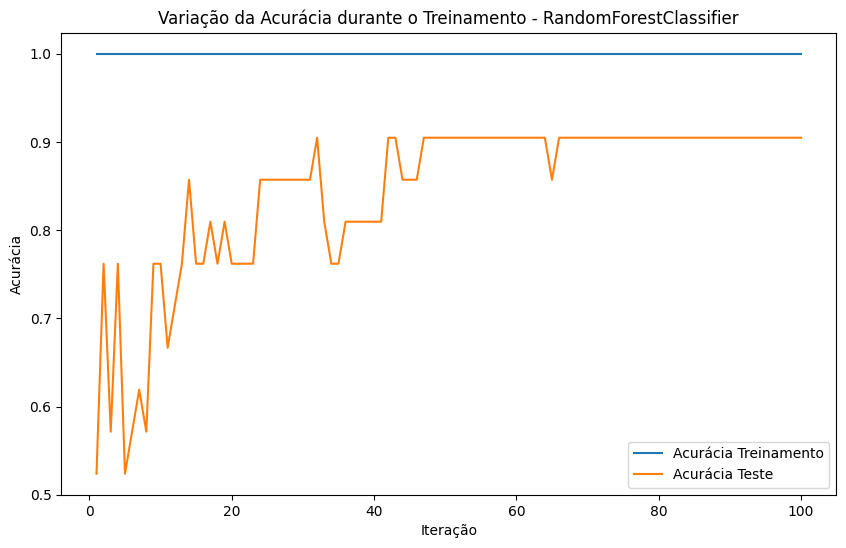

In [175]:
# Plotar a variação da acurácia durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_accuracies, label='Acurácia Treinamento')
plt.plot(range(1, 101), test_accuracies, label='Acurácia Teste')
plt.xlabel('Iteração')
plt.ylabel('Acurácia')
plt.title('Variação da Acurácia durante o Treinamento - RandomForestClassifier')
plt.legend()
plt.show()

In [180]:
print('\nMatriz de Confusão:')
print(confusion_matrix(y_test, y_pred))


Matriz de Confusão:
[[ 9  2]
 [ 0 10]]


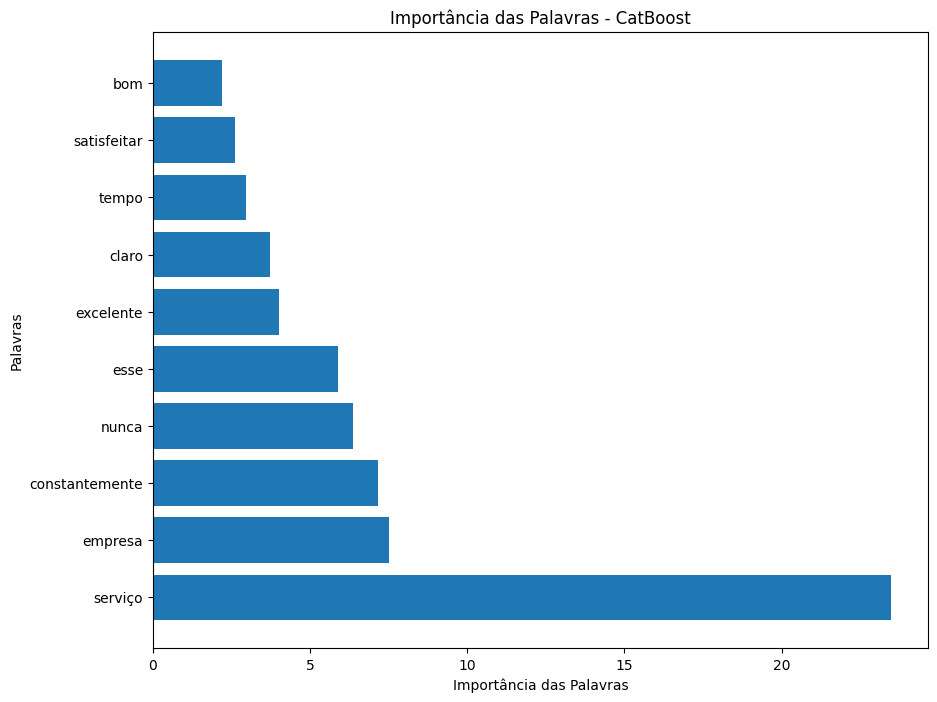

In [185]:
feature_importance = catboost_model.get_feature_importance()
feature_names = vectorizer.get_feature_names_out()

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotar a importância das características (palavras)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][0:10], importance_df['Importance'][0:10])
plt.xlabel('Importância das Palavras')
plt.ylabel('Palavras')
plt.title('Importância das Palavras - CatBoost')
plt.show()


As palavras que, nos comentários, foram mais relevantes para o processo decisório do classificador, são serviço, emrpesa, constantemente, nunca, esse, excelente. Esse ranking da feature importance indica que os comentários que falam sobre a variabildiade/frequência dos serviços

ROC-AUC: 0.9909


<Figure size 1000x600 with 0 Axes>

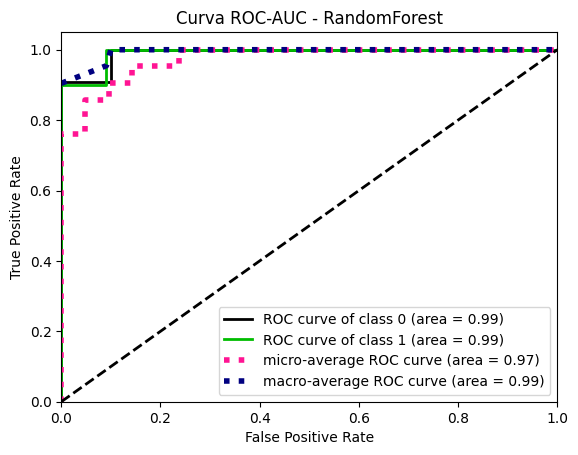

In [187]:
y_probs = rf_classifier.predict_proba(X_test_vectorized)

# Calcular o ROC-AUC
roc_auc = roc_auc_score(y_test, y_probs[:, 1])
print(f'ROC-AUC: {roc_auc:.4f}')

# Plotar a curva ROC-AUC
plt.figure(figsize=(10, 6))
plot_roc_curve(y_test, y_probs)
plt.title('Curva ROC-AUC - RandomForest')
plt.show()


A curva ROC indica que o modelo é eficaz na classificação tanto de comentários negativos, como os positivos.